# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (3 балла)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# !ls "/content/drive/My Drive/Colab Notebooks"
!cp -r "/content/drive/My Drive/Colab Notebooks/get_dataset.py" "get_dataset.py"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Prepare the data


In [0]:
from math import ceil 
from copy import deepcopy
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from torch.autograd import Variable
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
import scipy.stats as sts
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import torchsummary
np.set_printoptions(suppress=True)

plt.style.use('Solarize_Light2')
%matplotlib inline

device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done
45 45


In [36]:
data.shape

(13143, 45, 45, 3)

In [0]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
image_h, image_w = IMAGE_H, IMAGE_W
# у нас цветные изображения
N_CHANNELS = data.shape[3]

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

In [0]:
data = (data - data.min(axis=(1, 2), keepdims=True)) / (data.max(axis=(1, 2), keepdims=True) - data.min(axis=(1, 2), keepdims=True))

# We shoud not use train_test_split as long as we also have 'attrs' dataframe
X_train, X_val, attrs_train, attrs_val = train_test_split(data, attrs, train_size=TRAIN_SIZE, random_state=3)

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6, c=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, c)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        try:
            if c > 1:
                plt.imshow(images[i].reshape((h, w, c)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            elif c == 1:
                plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')

            plt.xticks(())
            plt.yticks(())
        except:
            pass

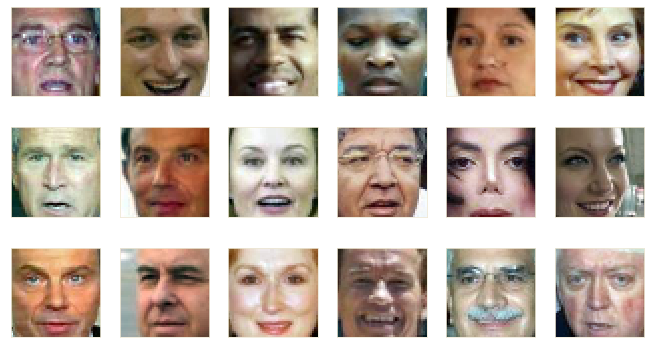

In [7]:
plot_gallery(X_train, image_h, image_w)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [0]:
# <тут Ваш код>
class Dataset(data_utils.Dataset):
  def __init__(self, dataset, labels=None, compose=None):
    self.dataset = dataset
    self.labels = labels
    self.len_ = len(self.dataset)
    self.compose = compose
    
  def __len__(self):
    return self.len_

  def __getitem__(self, ind): 
    x = self.dataset[ind] if self.compose is None else self.compose(self.dataset[ind])
    if self.labels is None:
      return x
    else: 
      return x, self.labels[ind]

compose = transforms.Compose([
                              transforms.ToTensor(),
                              ])    

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [0]:
N_OUT = 256

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(N_CHANNELS, 64, 4, 1, padding=1, padding_mode='same'),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.03),
        nn.Conv2d(64, 64, 3, 1, padding=1, padding_mode='same'),
        nn.LeakyReLU(0.03),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, 4, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.03),
        nn.Conv2d(128, 128, 3, 1),
        nn.LeakyReLU(0.03),
        nn.MaxPool2d(2, padding=1),

        nn.Conv2d(128, 256, 4, 1),
        nn.Dropout(0.3),
        nn.LeakyReLU(0.03),
        nn.Conv2d(256, 224, 3, 1),
        nn.LeakyReLU(0.03),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(224 * 2 * 2, N_OUT),
    )

  def forward(self, x):
    return self.encoder(x)

class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.lc = nn.Linear(N_OUT, 256 * 2 * 2)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 160, 3, 1),
        nn.LeakyReLU(0.03),

        nn.ConvTranspose2d(160, 128, 4, 2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.03),

        nn.ConvTranspose2d(128, 92, 3, 1),
        nn.Dropout(0.3),
        nn.LeakyReLU(0.03),

        nn.ConvTranspose2d(92, 64, 3, 2),
        nn.LeakyReLU(0.03),
        
        nn.ConvTranspose2d(64, 32, 3, 2),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.03),


        nn.ConvTranspose2d(32, 3, 3, 1),
        nn.Sigmoid(),

    )

  def forward(self, x):
    return self.decoder(self.lc(x).view(-1, 256, 2, 2))

class ConvAutoEncoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = Encoder()
      self.decoder = Decoder()  

    def forward(self, x):
      latent = self.encoder(x)
      reconstructed = self.decoder(latent) 
      return reconstructed, latent 


# class UnderCompleteAutoEncoder(nn.Module):
#   """ Сжимающий автоэнкодер """
#   def __init__(self, input_dim, hid_dim1, hid_dim2, hid_dim3, zdim):
#     super().__init__()
#     self.dims = [input_dim, hid_dim1, hid_dim2, hid_dim3, zdim]
#     self.encoder = nn.Sequential(
#         nn.Linear(input_dim, hid_dim1),
#         # nn.Dropout(0.3),
#         nn.ReLU(),
#         nn.Linear(hid_dim1, hid_dim2),
#         # nn.Dropout(0.3),
#         nn.ReLU(),
#         nn.Linear(hid_dim2, hid_dim3),
#         nn.ReLU(),
#         nn.Linear(hid_dim3, zdim)
#     )
#     self.decoder = nn.Sequential(
#         nn.Linear(zdim, hid_dim3),
#         nn.ReLU(),
#         nn.Linear(hid_dim3, hid_dim2),
#         nn.ReLU(),
#         nn.Linear(hid_dim2, hid_dim1),
#         nn.ReLU(),
#         nn.Linear(hid_dim1, input_dim)
#     )

#   def forward(self, x):
#     out_shape = x.shape
#     if len(x.shape) > 2:
#       x = x.view(-1, self.dims[0])
#     latent_code = self.encoder(x)
#     reconstruction = torch.tanh(self.decoder(latent_code))
#     return reconstruction.view(*out_shape), latent_code


# input_dim = np.prod(X_train.shape[1:]) # 45 * 45 * 3
# hid_dim1 = 3000
# hid_dim2 = 1500
# hid_dim3 = 500
# zdim = 100 
# autoencoder = UnderCompleteAutoEncoder(input_dim, hid_dim1, hid_dim2, hid_dim3, zdim).to(device)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [0]:
criterion = nn.MSELoss()

autoencoder = ConvAutoEncoder().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.0012)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

In [0]:
def reprocess(x_vals):
  return [x.data.cpu().numpy().transpose((1, 2, 0)) for x in x_vals]

In [0]:
# <тут Ваш код тренировки автоэнкодера>

def train(model, optimizer, criterion, train_loader, epochs, seed):
  model.to(device)
  np.random.seed(seed)
  history_loss = []  
  for epoch in tqdm_notebook(range(epochs)):
    running_loss = .0
    for i, x_val in enumerate(train_loader):
      optimizer.zero_grad()
      x_val = x_val.float().to(device)
      rec, lat = model(x_val)
      loss = criterion(rec, x_val)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if not (i + 1) % 300:
          print(f'epoch: {epoch} train_loss: {running_loss / 500:.5f}')
          history_loss.append(loss)
          running_loss = 0

    if not epoch % 10:
        plot_gallery(reprocess(x_val[:8]) + reprocess(rec[:8]), image_h, image_w, n_row=2, n_col=8)

  plt.figure(figsize=(8, 8))
  plt.plot(history_loss, label='train_loss')
  plt.legend()
  plt.show()

In [0]:
train_dataset = Dataset(X_train, compose=compose)
train_loader = data_utils.DataLoader(train_dataset, batch_size=48, num_workers=1, shuffle=True, drop_last=True)
train(autoencoder, optimizer, criterion, train_loader, 10, 1)
# Train 30-40 epochs 

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [0]:
torch.save(autoencoder.state_dict(), './drive/My Drive/Colab Notebooks/AE_lfw.pth')
# autoencoder.state_dict()

In [0]:
params = torch.load('./drive/My Drive/Colab Notebooks/AE_lfw.pth', map_location=device)
autoencoder.load_state_dict(params)
autoencoder.eval()

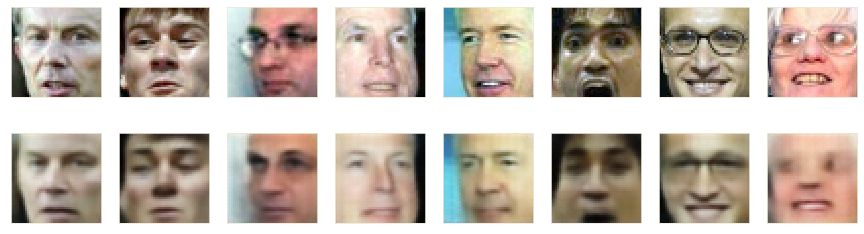

In [293]:
val_dataset = Dataset(X_val, compose=compose)
val_loader = data_utils.DataLoader(val_dataset, batch_size=32, num_workers=1, shuffle=True, drop_last=True)

# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
items = next(iter(val_loader))
with torch.no_grad():
  rec, lat = autoencoder(items.float().to(device))
  plot_gallery(reprocess(items[:8]) + reprocess(rec[:8]), image_h, image_w, n_row=2, n_col=8)  

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

Генерация не самая удачная, даже если подгонять под наши mean и std


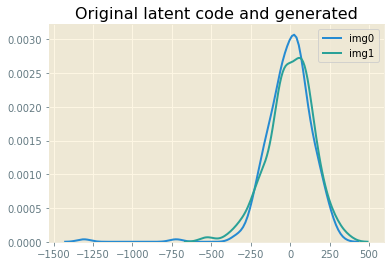

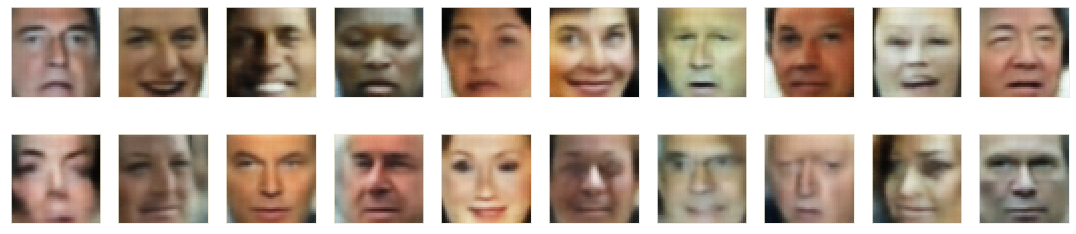

In [294]:
def order_dist(arr1, arr2):
  """ Reorders arr2 depending on arr1 vals position"""
  order = []
  arr2 = np.sort(arr2)
  for i, v in enumerate(arr1):
    norm = abs(arr2 - v)
    ind = np.argmin(norm)
    if ind not in order: 
      order.append(ind)
    else:
        inds = np.argsort(norm)
        c = 1
        while True:
          if inds[c] not in order:
            order.append(inds[c])
            break 
          c += 1
  return arr2[order]


def plt_dist(dists):
  """ Plot distribution, in our case it is similar to normal """
  for i, l in enumerate(dists):
    sns.kdeplot(l, label=f'img{i}')


# сгенерируем 25 рандомных векторов размера latent_space

loader = iter(data_utils.DataLoader(train_dataset, batch_size=20, shuffle=False))
items = next(loader).float().to(device)
autoencoder.eval()
imgs = []
with torch.no_grad():
  rec, lat = autoencoder(items)
  for i, l in enumerate(lat.data.cpu().numpy()):

    # Generate normal latent code with mean and std
    eps = 0.05
    m, s = sts.norm.fit(l, loc=l.mean(), scale=l.std())
    rnd_l = sts.norm.rvs(loc=m, scale=s, size=len(l))


    rnd_l = order_dist(l, rnd_l)

    rec_rnd = autoencoder.decoder(torch.tensor(rnd_l, dtype=torch.float).to(device))
    imgs += reprocess(rec_rnd)
  plt_dist([l, rnd_l])
  plt.title('Original latent code and generated')

  plot_gallery(imgs, IMAGE_H, IMAGE_W, n_row=2, n_col=10)   
print(f'Генерация не самая удачная, даже если подгонять под наши mean и std') 

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Фото из среднего латентного кода и фото разницы кодов


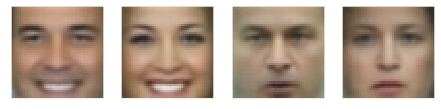

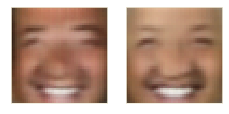

In [285]:
# Initially all column types - object  
attrs_train = attrs_train.astype(dtype='float32')
# attrs_train.columns



# Get groups of definite images
n = 700
sm = attrs_train.nlargest(n, 'Smiling')
sm_male = sm.where(attrs_train['Male'] > 1.7).dropna()
sm_female = sm.where(attrs_train['Male'] < -1.7).dropna()

fr = attrs_train.nlargest(n, 'Frowning')
fr_male = fr.where(attrs_train['Male'] > 1.7).dropna()
fr_female = fr.where(attrs_train['Male'] < -0.6).dropna()



print(f'Фото из среднего латентного кода и фото разницы кодов')

def plt_code(vals, xlims=(), ylims=()):
  fig, ax = plt.subplots(figsize=(10, 8))
  if not isinstance(vals, np.ndarray) and not isinstance(vals, list):
    vals = vals.data.cpu().numpy()
  for i, v in enumerate(vals):
    sns.scatterplot(range(len(v)), v, label=f'{i}', ax=ax)
  
  ax.set_xlim(*xlims)
  ax.set_ylim(*ylims)


b = 20
autoencoder.eval()
with torch.no_grad():
  # Smile Loaders 
  sm_male_loader = next(iter(data_utils.DataLoader(Dataset(data[sm_male.index], compose=compose), batch_size=b))).float().to(device)
  sm_female_loader = next(iter(data_utils.DataLoader(Dataset(data[sm_female.index], compose=compose), batch_size=b))).float().to(device)
  
  # Frown Loaders
  fr_male_loader = next(iter(data_utils.DataLoader(Dataset(data[fr_male.index], compose=compose), batch_size=b))).float().to(device)
  fr_female_loader = next(iter(data_utils.DataLoader(Dataset(data[fr_female.index], compose=compose), batch_size=b))).float().to(device)



  # Reconstruction of Smile Loaders
  rec_sm_male, lat_sm_male = autoencoder(sm_male_loader)
  rec_sm_female, lat_sm_female = autoencoder(sm_female_loader)

  # Reconstruction of Frown Loaders
  rec_fr_male, lat_fr_male = autoencoder(fr_male_loader)
  rec_fr_female, lat_fr_female = autoencoder(fr_female_loader)



  # Mean Latent of Smile Loaders
  m_lat_sm_male = lat_sm_male.data.cpu().numpy().mean(axis=0)  
  m_lat_sm_female = lat_sm_female.data.cpu().numpy().mean(axis=0)  

  # Mean Latent of Frown Loaders
  m_lat_fr_male = lat_fr_male.data.cpu().numpy().mean(axis=0)  
  m_lat_fr_female = lat_fr_female.data.cpu().numpy().mean(axis=0)  



  # Reconstruction of Mean Latent of Smile Loaders
  rec_m_lat_sm_male = autoencoder.decoder(torch.tensor(m_lat_sm_male, dtype=torch.float32).to(device))
  rec_m_lat_sm_female = autoencoder.decoder(torch.tensor(m_lat_sm_female, dtype=torch.float32).to(device))

  # Reconstruction of Mean Latent of Frown Loaders
  rec_m_lat_fr_male = autoencoder.decoder(torch.tensor(m_lat_fr_male, dtype=torch.float32).to(device))
  rec_m_lat_fr_female = autoencoder.decoder(torch.tensor(m_lat_fr_female, dtype=torch.float32).to(device))

  # Plot Reconstructions 
  recs = []
  for r in [rec_m_lat_sm_male, rec_m_lat_sm_female, rec_m_lat_fr_male, rec_m_lat_fr_female]:
    recs += reprocess(r)

  plot_gallery(recs, image_h, image_w, n_row=1, n_col=4)


  # Plot Reconstruction of code difference
  diff_recs = []
  diff_lats = [m_lat_sm_male - m_lat_fr_male, m_lat_sm_female - m_lat_fr_female] # Latent diffs to add !!!
  for l in diff_lats:
    r = autoencoder.decoder(torch.tensor(l, dtype=torch.float32).to(device))
    diff_recs += reprocess(r)
  plot_gallery(diff_recs, image_h, image_w, n_row=1, n_col=2)


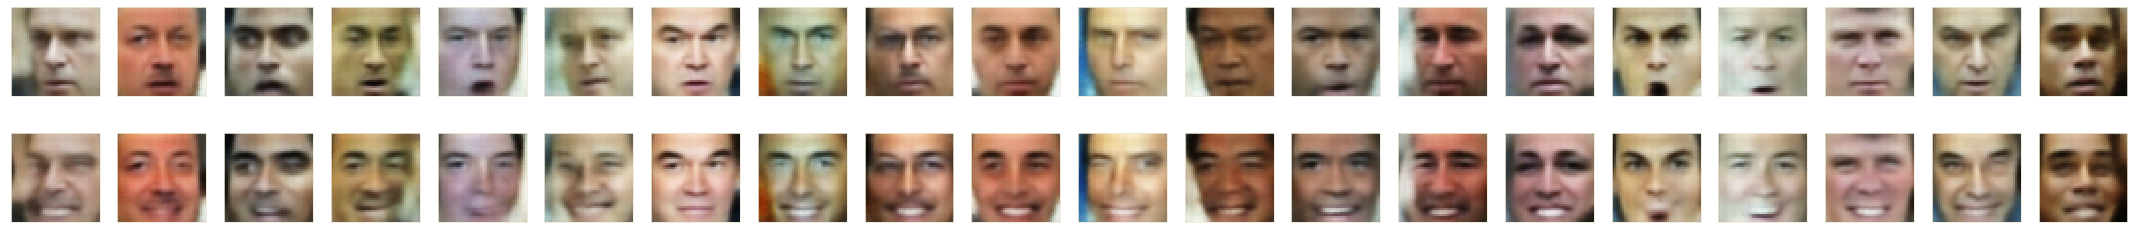

In [286]:
# Make frowning male smile 
fr_male_loader = iter(data_utils.DataLoader(Dataset(data[fr_male.index], compose=compose), batch_size=b))
with torch.no_grad():
  items = next(fr_male_loader).float().to(device)
  # item = data[11571]
  # rec1, l = autoencoder(compose(item).unsqueeze(0).float().to(device))
  rec1, l = autoencoder(items)
  l += torch.tensor(diff_lats[0]).to(device)
  rec2 = autoencoder.decoder(l)
  plot_gallery(reprocess(rec1) + reprocess(rec2), image_h, image_w, n_row=2, n_col=b)

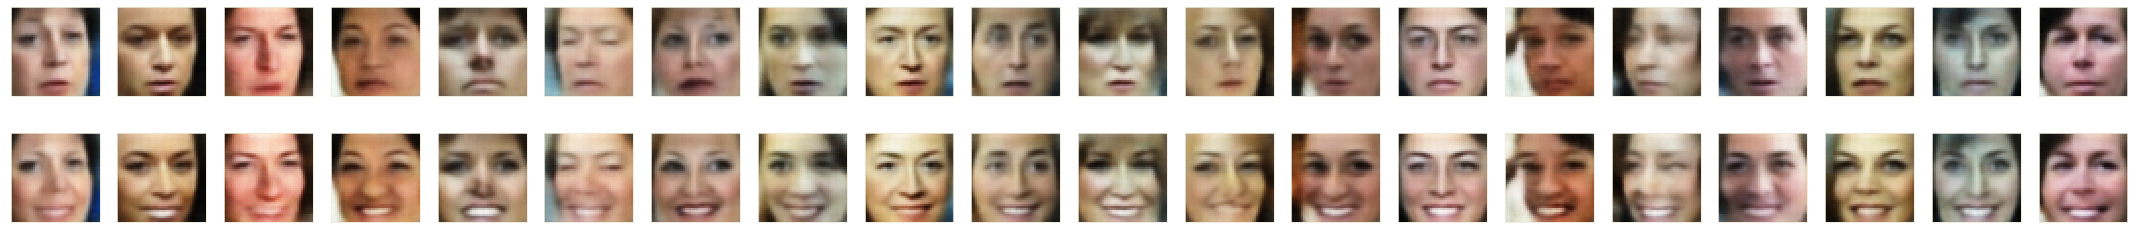

In [287]:
# Make frowning female smile 
fr_female_loader = iter(data_utils.DataLoader(Dataset(data[fr_female.index], compose=compose), batch_size=b))
with torch.no_grad():
  items = next(fr_female_loader).float().to(device)
  rec1, l = autoencoder(items)
  l += torch.tensor(diff_lats[1]).to(device)
  rec2 = autoencoder.decoder(l)
  plot_gallery(reprocess(rec1) + reprocess(rec2), image_h, image_w, n_row=2, n_col=b)


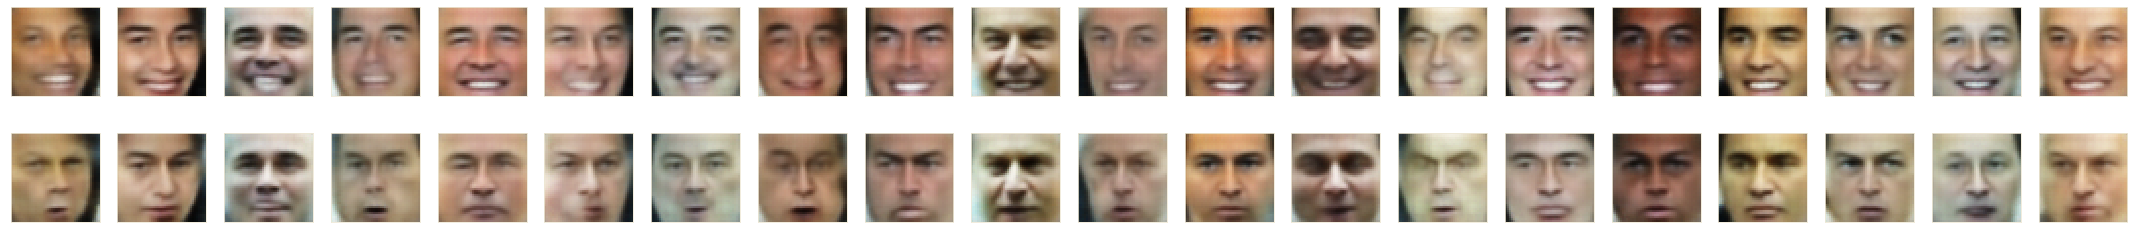

In [288]:
# Make smiling male frown 
sm_male_loader = iter(data_utils.DataLoader(Dataset(data[sm_male.index], compose=compose), batch_size=b))
with torch.no_grad():
  items = next(sm_male_loader).float().to(device)
  rec1, l = autoencoder(items)
  l -= torch.tensor(diff_lats[0]).to(device)
  rec2 = autoencoder.decoder(l)
  plot_gallery(reprocess(rec1) + reprocess(rec2), image_h, image_w, n_row=2, n_col=b)

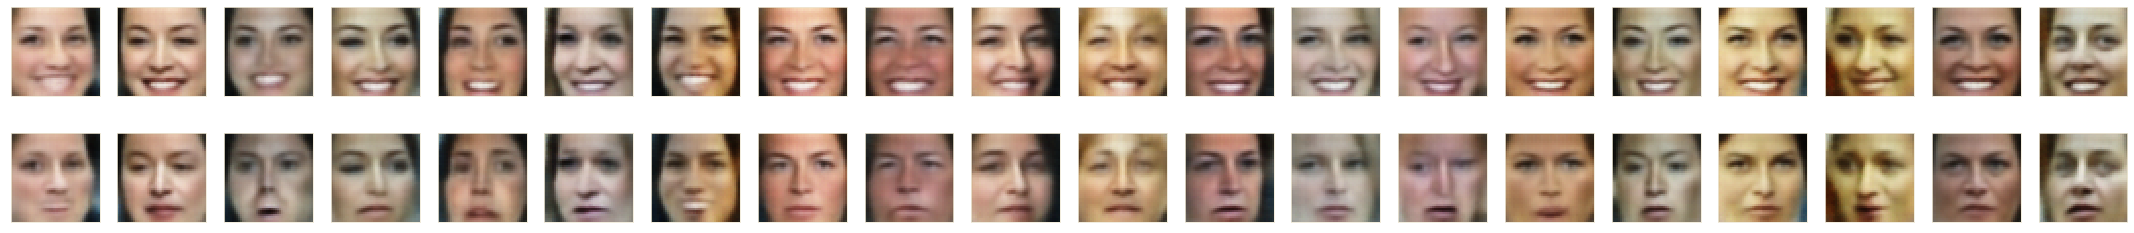

In [289]:
# Make smiling female frown 
sm_female_loader = iter(data_utils.DataLoader(Dataset(data[sm_female.index], compose=compose), batch_size=b))
with torch.no_grad():
  items = next(sm_female_loader).float().to(device)
  rec1, l = autoencoder(items)
  l -= torch.tensor(diff_lats[1]).to(device)
  rec2 = autoencoder.decoder(l)
  plot_gallery(reprocess(rec1) + reprocess(rec2), image_h, image_w, n_row=2, n_col=b)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# Conditional Autoencoder (3 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет

Как вы уже догадались, здесь мы будем использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/)

Если он вам очень не нравится, можете загуглить любой другой, в котором будет четкое разделение картинок по классам.

In [164]:
# Site with explanation how to load MNIST http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/ with mlxtend

# Mount on drive
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!yes n | gunzip t*-ubyte.gz

# Load to variables
from mlxtend.data import loadlocal_mnist
X, y = loadlocal_mnist(
        images_path='./train-images-idx3-ubyte', 
        labels_path='./train-labels-idx1-ubyte')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  19.2M      0 --:--:-- --:--:-- --:--:-- 19.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   258k      0 --:--:-- --:--:-- --:--:--  258k


In [165]:
X = X / 255
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33, shuffle=True)
X_train.shape, X_val.shape

((48000, 784), (12000, 784))

In [0]:
IMAGE_H = 28
IMAGE_W = 28
image_h, image_w = IMAGE_H, IMAGE_W

N_CHANNEL = 1

N_CLASS = 10

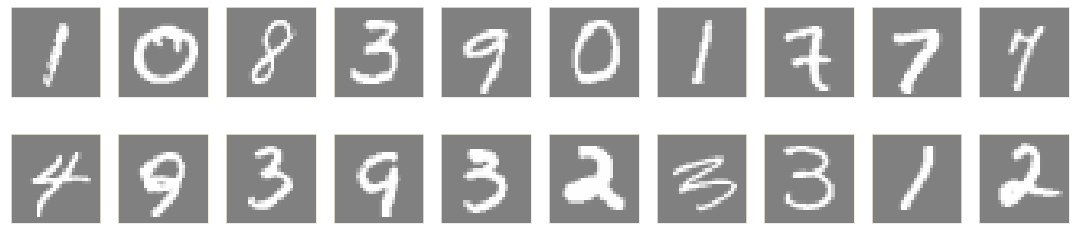

In [170]:
plot_gallery(X_train[:20], image_h, image_w, n_row=2, n_col=10, c=1)

In [0]:
# In our case we are working with data in range [0, 1], BatchNorm2d only worsen  
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.lc = nn.Linear(N_CLASS + IMAGE_H * IMAGE_W, IMAGE_H * IMAGE_W)
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, 3, 1), # -1x32x10x10
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # -1x32x5x5

        nn.Conv2d(32, 16, 3, 2, 1), # -1x16x3x3
        nn.ReLU(),
        nn.MaxPool2d(2, 1), # -1x16x2x2

        nn.Flatten(),
        nn.Linear(16 * 2 * 2, 128),
        nn.Sigmoid(),
    )

  def forward(self, x):
    x = self.lc(x)
    x = x.view(-1, N_CHANNEL, IMAGE_H, IMAGE_W) # -1x1x28x28
    x = self.encoder(x)
    return x


class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.lc = nn.Linear(128 + N_CLASS, 16 * 2 * 2)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(16, 32, 3, 2), 
        nn.ReLU(),

        nn.ConvTranspose2d(32, 16, 5, 3, 1), 
        nn.ReLU(),

        nn.ConvTranspose2d(16, 1, 2, 2, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.lc(x).view(-1, 16, 2, 2)
    x = self.decoder(x)
    return x


class CAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
  
  def forward(self, x, y):
    x = torch.cat((x, y.view(-1, 1, N_CLASS, 1)), dim=2)
    x = x.view(-1, 28 * 28 + N_CLASS)

    latent = torch.cat((self.encoder(x), y), dim=1)
    reconstructed = self.decoder(latent) 
    return reconstructed, latent

In [0]:
# <тут Ваш код тренировки автоэнкодера>
def train_loss(model, optimizer, criterion, train_loader):
  model.train()
  running_loss = .0
  for i, (x_val, y) in enumerate(train_loader):
    optimizer.zero_grad()

    # x_val has shape -1x1x28*28x1
    # in forward y has shape -1x1x10x1
    # one_hot takes 1d array of labels and returns matrix
    x_val = x_val.float().to(device)
    y = one_hot(y, n_classes=N_CLASS)
    y = y.to(device)
    
    # encoder cats x_val & y along 2-axis and passes through convs
    rec, lat = model(x_val, y)

    # rec has shape -1x1x28x28
    loss = criterion(rec, x_val.view_as(rec))
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(train_loader)


def test_loss(model, criterion, test_loader):
  model.eval()
  running_loss = .0

  with torch.no_grad():
    for i, (x_val, y) in enumerate(test_loader):
      # Same as in train_loss
      x_val = x_val.float().to(device)
      y = one_hot(y, n_classes=N_CLASS)
      y = y.to(device)

      rec, lat = model(x_val, y)

      loss = criterion(rec, x_val.view_as(rec))

      running_loss += loss.item()

  return running_loss / len(test_loader)


def generate(model, title='', seed=3):
  model.eval()
  torch.manual_seed(seed)
  with torch.no_grad():
    code = torch.randn(10, 128).to(device)
    code = torch.sigmoid(code)

    y = torch.arange(0, N_CLASS, 1).view(-1, 1)
    # print(f'random class: {y.flatten().data}')
    y = one_hot(y).to(device)

    code = torch.cat((code, y), dim=1)

    rec = model.decoder(code)
    plot_gallery(reprocess(rec), image_h, image_w, n_col=10, n_row=1, c=1)
    plt.title(title, loc='center')


def one_hot(label, n_classes=N_CLASS):
  onehot = torch.zeros(label.size(0), n_classes) # label_size = batch_sizex1
  label = label.view(-1, 1).long()
  
  onehot.scatter_(1, label.data, 1)
  return onehot


def train(model, optimizer, criterion, train_loader, test_loader, epochs, seed):
  np.random.seed(seed)
  history_loss = []
  best_test_loss = np.inf
  for e in range(epochs):
    tr_loss = train_loss(model, optimizer, criterion, train_loader)
    ts_loss = test_loss(model, criterion, test_loader)
    generate(model, f'gen. epoch {e + 1}', seed)
    history_loss.append((tr_loss, ts_loss)) 

    print(f'Epoch {e + 1}, Train Loss: {tr_loss:.4f}, Test Loss: {ts_loss:.4f}')      

    if best_test_loss > ts_loss:
      best_test_loss = ts_loss
      patience_counter = 1
    else:
      patience_counter += 1 

    if patience_counter > 3:
      print(f'Test Loss: {ts_loss} > Best Test Loss: {best_test_loss}')
      break

  tr_loss_hist, test_loss_hist = list(zip(*history_loss))

  plt.figure(figsize=(8, 8))
  plt.plot(tr_loss_hist, label='train_loss')
  plt.plot(test_loss_hist, label='test_loss')
  plt.legend()
  plt.show()    

In [0]:
# <тут Ваш код>
class MinstDataset(Dataset):
  def __init__(self, dataset, labels=None, compose=None):
    super().__init__(dataset, labels, compose)

  def _prepare(self, x):
    return x.reshape((28 * 28, 1))

  def __getitem__(self, ind):
    x = self._prepare(self.dataset[ind])
    x = x if self.compose is None else self.compose(x)
    if self.labels is None:
      return x
    else: 
      return x, self.labels[ind]


compose = transforms.Compose([
                              transforms.ToTensor(),
                              ])    

train_dataset = MinstDataset(X_train, y_train, compose=compose)
val_dataset = MinstDataset(X_val, y_val, compose=compose)

In [0]:
# BCELoss results in worse image plots 
criterion = nn.MSELoss()

autoencoder = CAutoEncoder().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.0011)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.3)

Epoch 1, Train Loss: 0.0683, Test Loss: 0.0512
Epoch 2, Train Loss: 0.0364, Test Loss: 0.0261
Epoch 3, Train Loss: 0.0213, Test Loss: 0.0184
Epoch 4, Train Loss: 0.0162, Test Loss: 0.0148


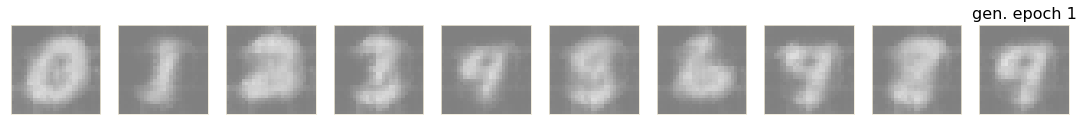

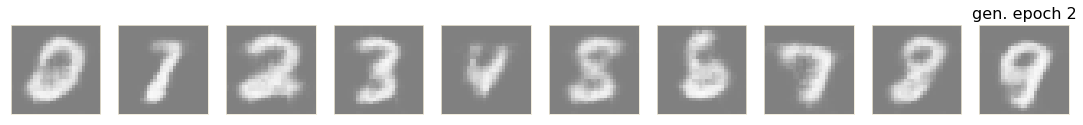

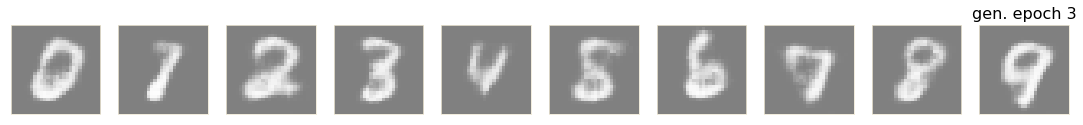

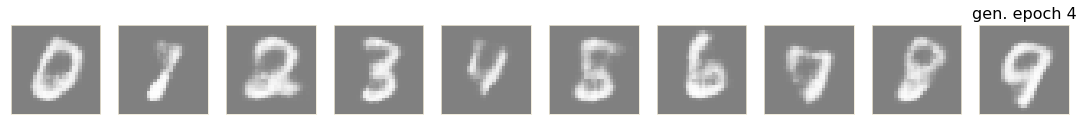

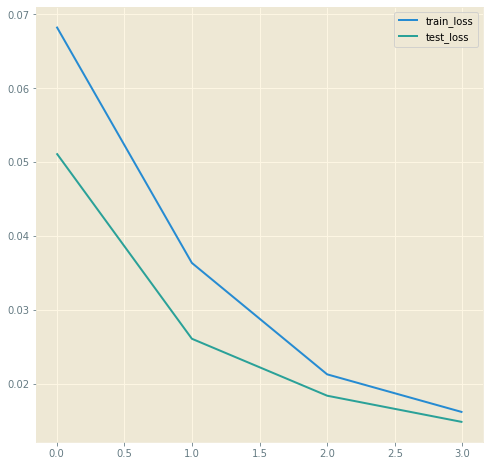

In [315]:
# batch_size = 56-64 would be optimal, size 32-48 would be bad idea
# Example learning with batch_size = 64

train_loader = data_utils.DataLoader(train_dataset, batch_size=64, num_workers=1, shuffle=True, drop_last=True)
val_loader = data_utils.DataLoader(val_dataset, batch_size=64, num_workers=1, drop_last=True)
train(autoencoder, optimizer, criterion, train_loader, val_loader, 4, 3)

In [0]:
# Val_dataset plot
x_val, y = next(iter(val_loader))
with torch.no_grad():
  x_val = x_val.float().to(device)
  y = one_hot(y, n_classes=N_CLASS).to(device)
  rec, lat = autoencoder(x_val, y)
  plot_gallery(reprocess(x_val[:8]) + reprocess(rec[:8]), image_h, image_w, n_row=2, n_col=8, c=1)  

## Sampling


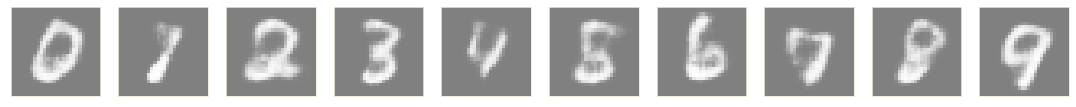

In [316]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
autoencoder.eval()
torch.manual_seed(3)

with torch.no_grad():
  code = torch.randn(10, 128).to(device)
  code = torch.sigmoid(code)
  y = torch.arange(0, N_CLASS, 1).view(-1, 1)
  # print(f'random class: {y.flatten().data}')
  y = one_hot(y).to(device)

  code = torch.cat((code, y), dim=1)

  rec = autoencoder.decoder(code)
  plot_gallery(reprocess(rec), image_h, image_w, n_col=10, n_row=1, c=1)

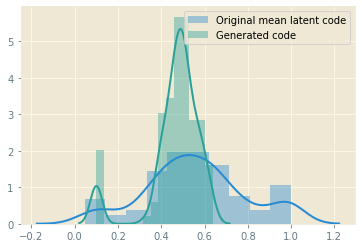

In [318]:
sns.distplot(lat.data.cpu().numpy().mean(axis=0), label=f'Original mean latent code')
sns.distplot(code.data.cpu().numpy().mean(axis=0), label=f'Generated code')
plt.legend()

In [0]:
torch.save(autoencoder.state_dict(), './drive/My Drive/Colab Notebooks/CAE_mnist.pth')

In [0]:
params = torch.load('./drive/My Drive/Colab Notebooks/CAE_mnist.pth', map_location=device)
autoencoder.load_state_dict(params)
autoencoder.eval()

Splendid! Вы великолепны!

Теперь давайте сделаем следующее: посмотрим на то, как выглядит латентное пространство векторов, соответствующих нашим картинкам. 
Для этого вам нужно:
1.  прогнать картинки из датасета через encoder, получить латентные векторы
2. Прогнать векторы через TSNE, получить их двумерную проекцию
3. Изобразить полученные после TSNE двумерные векторы на плоскости с помощью plt.scatter, покрасив точки в цвета в зависимости от класса картинки, которой она соответствует. (как красить точки, см. в документации к plt.scatter). 
4. Подумать, что вы видите и записать свои мысли

In [0]:
# <тут код получения латентных векторов, прогона через TSNE и рисования scatter plot>
from sklearn.manifold import TSNE

autoencoder.eval()
n = 2000

x_val, y = next(iter(data_utils.DataLoader(val_dataset, num_workers=1, batch_size=n)))
with torch.no_grad():
  x_val = x_val.float().to(device)
  y = one_hot(y, n_classes=N_CLASS).to(device)
  rec, lat = autoencoder(x_val, y)
  lat = lat.data.cpu().numpy()

x_val_tsne1 = TSNE(n_components=2, init='pca', random_state=33).fit_transform(lat)
x_val_tsne2 = TSNE(n_components=2, init='random', random_state=33).fit_transform(lat)

y = y_val[:n]

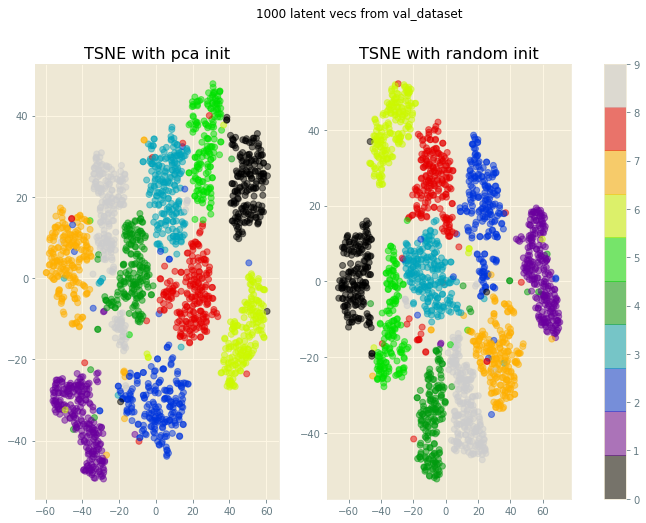

In [321]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

img = ax[0].scatter(x_val_tsne1[:, 0], x_val_tsne1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', N_CLASS))
ax[0].set_title('TSNE with pca init')
ax[1].scatter(x_val_tsne2[:, 0], x_val_tsne2[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', N_CLASS))
ax[1].set_title('TSNE with random init')
plt.suptitle('1000 latent vecs from val_dataset')
plt.colorbar(img, ax=ax)

<тут ваши мысли по поводу того, что вы видите на рисунке>

Первое что приходит в голову это то, что классы в многомерном пространстве при проецировании на 2d хорошо разделимы и на картинке нету скученности(как если бы мы использовали sne). Кстати на сгенерированных картинках были проблемы в схожести классов(например 1 и 7, на картинке scatter-plot видно что они пересекаются).

# BONUS 1. (2 балла) 
### Variational Autoencoder

Если вы (надеюсь) осознали, в каком месте у conditional AE выше могли бы быть проблемы, то -- тадам!!

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [0]:
N_OUT = 256


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, padding_mode='same'), # 32x22x22 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.3),

            nn.Conv2d(32, 64, 4, 2, 1, padding_mode='same'), # 64x11x11
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),

            nn.Conv2d(64, 128, 3, 2, 1, padding_mode='same'), # 128x6x6
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),

            nn.Conv2d(128, 256, 3, 2, 1, padding_mode='same'), # 256x3x3
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3),
            
            nn.Flatten(), # 256 * 3 * 3
        )
    def forward(self, x):
      return self.encoder(x)


class VEncoder(Encoder):
    """ Inherits Encoder for LFW DATASET """
    def __init__(self):
        super().__init__()
        self.mu = nn.Linear(256 * 3 * 3, N_OUT)
        self.std = nn.Linear(256 * 3 * 3, N_OUT)

    def _bottleneck(self, x):
        return self.mu(x), self.std(x)

    def forward(self, x):
        x = super().forward(x)
        return self._bottleneck(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lc = nn.Linear(N_OUT, 256 * 3 * 3)
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(256, 128, 3, 1, 1, padding_mode='same'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),

            nn.Upsample(scale_factor=2), 
            nn.Conv2d(128, 64, 3, 1, 1, padding_mode='same'),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),

            nn.Upsample(scale_factor=2), 
            nn.Conv2d(64, 32, 3, 1, 1, padding_mode='same'),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.3),

            nn.Upsample(scale_factor=2), 
            nn.Conv2d(32, 3, 4, 1, padding_mode='same'),

            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.lc(x).view(-1, 256, 3, 3)
        return self.decoder(x)


class VDecoder(Decoder):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = super().forward(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VEncoder()
        self.decoder = VDecoder()

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp_(logsigma * 0.5)
            eps = Variable(std.data.new(std.size()).normal_())
            return mu + std * eps 
        else:
            return mu

    def forward(self, x):
        mu, logsigma = self.encoder(x)
        mu_z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(mu_z)
        return mu, logsigma, mu_z, reconstruction


# torchsummary.summary(VEncoder().to(device), ((3, 45, 45)))
# torchsummary.summary(VDecoder().to(device), ((100, )))
# torchsummary.summary(VAE().to(device), ((3, 45, 45)))

Определим лосс и его компоненты для VAE:

In [0]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -0.5 * (1 + logsigma - mu**2 - logsigma.exp()).sum()

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)


И обучим модель:

In [0]:
# <обучите модель, как и autoencoder>

# <тут Ваш код тренировки автоэнкодера>
def train_loss(model, optimizer, criterion, train_loader):
  model.train()
  running_loss = .0
  for i, x_val in enumerate(train_loader):
    optimizer.zero_grad()

    x_val = x_val.float().to(device)
    
    mu, logsigma, mu_z, rec = model(x_val)

    loss = loss_vae(x_val.view_as(rec), mu, logsigma, rec)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(train_loader) / (IMAGE_H * IMAGE_W)


def test_loss(model, criterion, test_loader):
  model.eval()
  running_loss = .0

  with torch.no_grad():
    for i, x_val in enumerate(test_loader):
      # Same as in train_loss
      x_val = x_val.float().to(device)

      mu, logsigma, mu_z, rec = model(x_val)

      loss = loss_vae(x_val.view_as(rec), mu, logsigma, rec)

      running_loss += loss.item()

  return running_loss / len(test_loader) / (IMAGE_H * IMAGE_W)


def generate(model, title='', seed=3):
  model.eval()
  torch.manual_seed(seed)
  with torch.no_grad():
    code = torch.randn(10, N_OUT).to(device)

    rec = model.decoder(code)
    # if len(rec.shape) != 4:
        # rec = rec.view(-1, N_CHANNEL, IMAGE_H, IMAGE_W)
    plot_gallery(reprocess(rec), image_h, image_w, n_col=10, n_row=1)
    plt.title(title, loc='center')

In [0]:
autoencoder = VAE().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.0011)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

In [0]:
train_dataset = Dataset(X_train, compose=compose)
val_dataset = Dataset(X_val, compose=compose)

Epoch 1, Train Loss: 143.6050, Test Loss: 142.2010
Epoch 2, Train Loss: 143.2630, Test Loss: 142.1490
Epoch 3, Train Loss: 143.0885, Test Loss: 142.0492
Epoch 4, Train Loss: 142.9615, Test Loss: 142.0181
Epoch 5, Train Loss: 142.8624, Test Loss: 141.9902


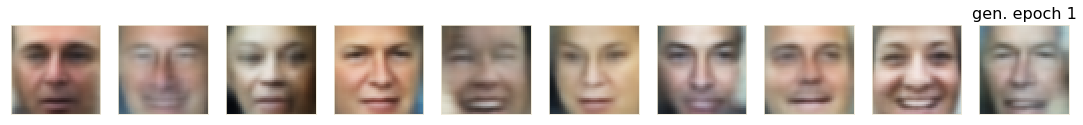

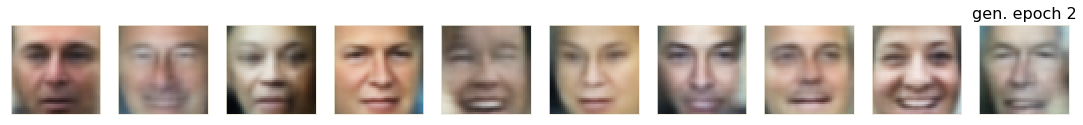

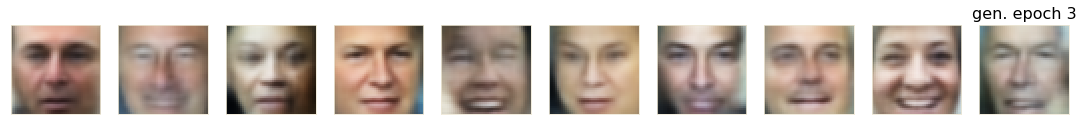

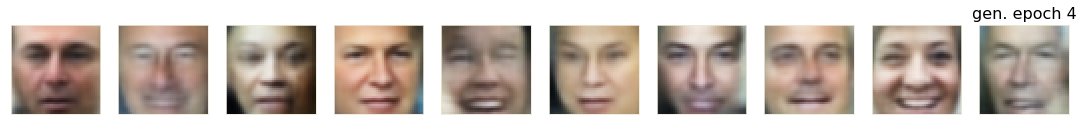

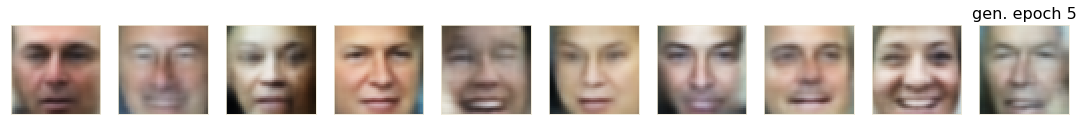

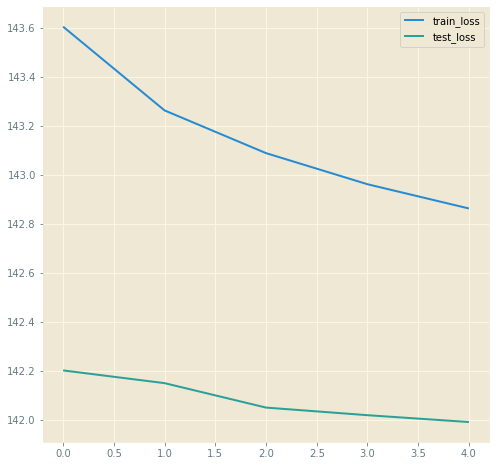

In [155]:
# 72, 56, 40, 64, 32, 48, 24, 80
b = 80
train_loader = data_utils.DataLoader(train_dataset, batch_size=b, num_workers=1, shuffle=True, drop_last=True)
val_loader = data_utils.DataLoader(val_dataset, batch_size=b, num_workers=1, drop_last=True)
train(autoencoder, optimizer, loss_vae, train_loader, val_loader, 5, 3)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

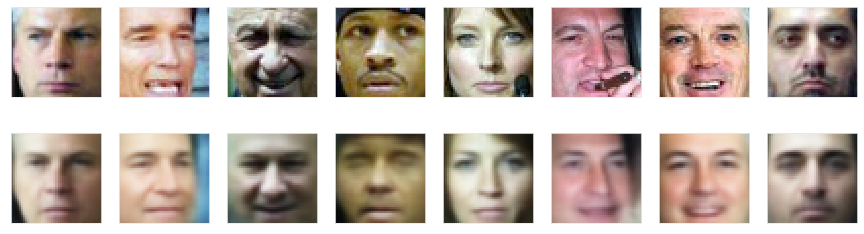

In [173]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

autoencoder.eval()
x_val = next(iter(data_utils.DataLoader(val_dataset, batch_size=32, num_workers=1, drop_last=True, shuffle=True)))
with torch.no_grad():
  x_val = x_val.float().to(device)
  mu, logsigma, mu_z, rec = autoencoder(x_val)
  plot_gallery(reprocess(x_val[:8]) + reprocess(rec[:8]), image_h, image_w, n_row=2, n_col=8)  

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие лица получатся:

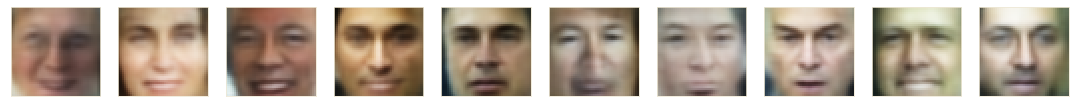

In [175]:
np.random.seed(33)
# вспомните про замечание из этого же ункта обычного AE про распределение латентных переменных
autoencoder.eval()
with torch.no_grad():
  z = np.array([np.random.normal(0, 1, N_OUT) for i in range(10)])
  z = torch.FloatTensor(z).to(device)
  output = autoencoder.decoder(z)
  plot_gallery(reprocess(output), image_h, image_w, n_col=10, n_row=1)

## Congrats v2.0!

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера

In [0]:
# <как вы уже догадались, тут Ваш код>

attrs_train = attrs_train.astype(dtype='float32')
n = 700

# Get groups of definite images
sm = attrs_train.nlargest(n, 'Smiling')
sm_male = sm.where(attrs_train['Male'] > 1.7).dropna()
sm_female = sm.where(attrs_train['Male'] < -1.7).dropna()

fr = attrs_train.nlargest(n, 'Frowning')
fr_male = fr.where(attrs_train['Male'] > 1.7).dropna()
fr_female = fr.where(attrs_train['Male'] < -0.6).dropna()


b = 20
autoencoder.eval()
with torch.no_grad():
  # Smile Loaders 
  sm_male_loader = next(iter(data_utils.DataLoader(Dataset(data[sm_male.index], compose=compose), batch_size=b))).float().to(device)
  sm_female_loader = next(iter(data_utils.DataLoader(Dataset(data[sm_female.index], compose=compose), batch_size=b))).float().to(device)
  
  # Frown Loaders
  fr_male_loader = next(iter(data_utils.DataLoader(Dataset(data[fr_male.index], compose=compose), batch_size=b))).float().to(device)
  fr_female_loader = next(iter(data_utils.DataLoader(Dataset(data[fr_female.index], compose=compose), batch_size=b))).float().to(device)


  # Reconstruction of Smile Loaders
  mu_sm_male, logsigma_sm_male, mu_z_sm_male, rec_sm_male = autoencoder(sm_male_loader)
  mu_sm_female, logsigma_sm_female, mu_z_sm_female, rec_sm_female = autoencoder(sm_male_loader)

  # Reconstruction of Frown Loaders
  mu_fr_male, logsigma_fr_male, mu_z_fr_male, rec_fr_male = autoencoder(fr_male_loader)
  mu_fr_female, logsigma_fr_female, mu_z_fr_female, rec_fr_female = autoencoder(fr_female_loader)


  # Mean Latent of Smile Loaders
  m_lat_sm_male = mu_z_sm_male.data.cpu().numpy().mean(axis=0)  
  m_lat_sm_female = mu_z_sm_female.data.cpu().numpy().mean(axis=0)  

  # Mean Latent of Frown Loaders
  m_lat_fr_male = mu_z_fr_male.data.cpu().numpy().mean(axis=0)  
  m_lat_fr_female = mu_z_fr_female.data.cpu().numpy().mean(axis=0)  


  diff_lats = [m_lat_sm_male - m_lat_fr_male, m_lat_sm_female - m_lat_fr_female] # Latent diffs(Male, Female) to add !!!

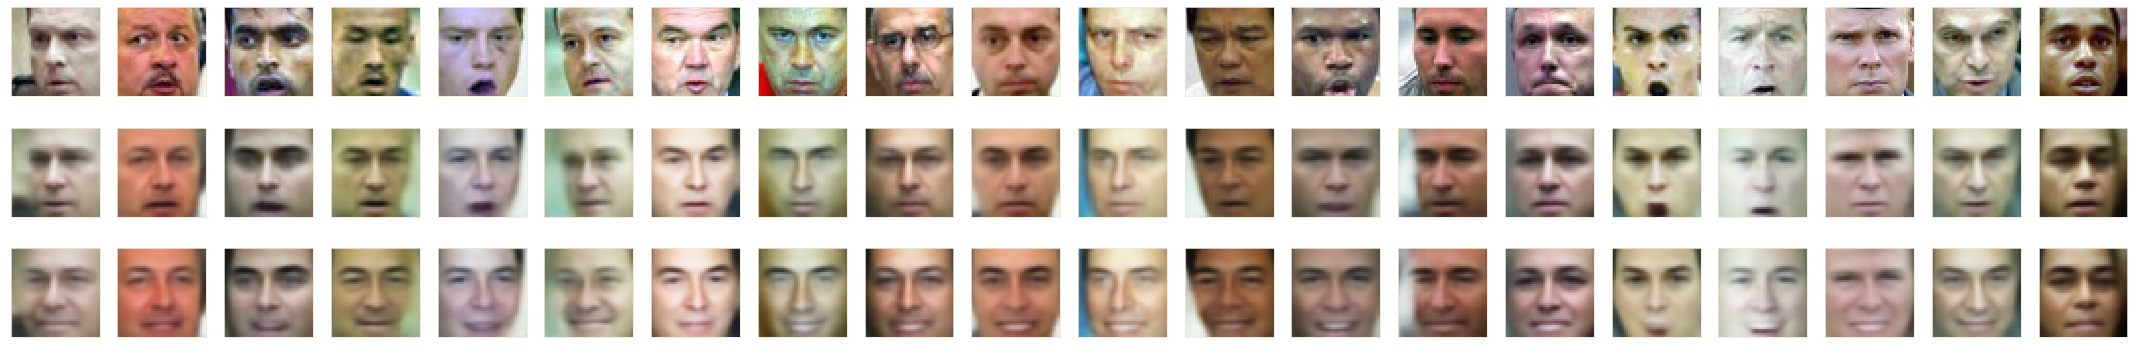

In [167]:
# Make frowning male smile 
fr_male_loader = iter(data_utils.DataLoader(Dataset(data[fr_male.index], compose=compose), batch_size=b))
with torch.no_grad():
  items = next(fr_male_loader).float().to(device)
  mu, logsigma, mu_z, rec1 = autoencoder(items)
  mu_z += torch.tensor(diff_lats[0]).to(device) # * 0.7 for slighter mask
  rec2 = autoencoder.decoder(mu_z)
  plot_gallery(reprocess(items) + reprocess(rec1) + reprocess(rec2), image_h, image_w, n_row=3, n_col=b)

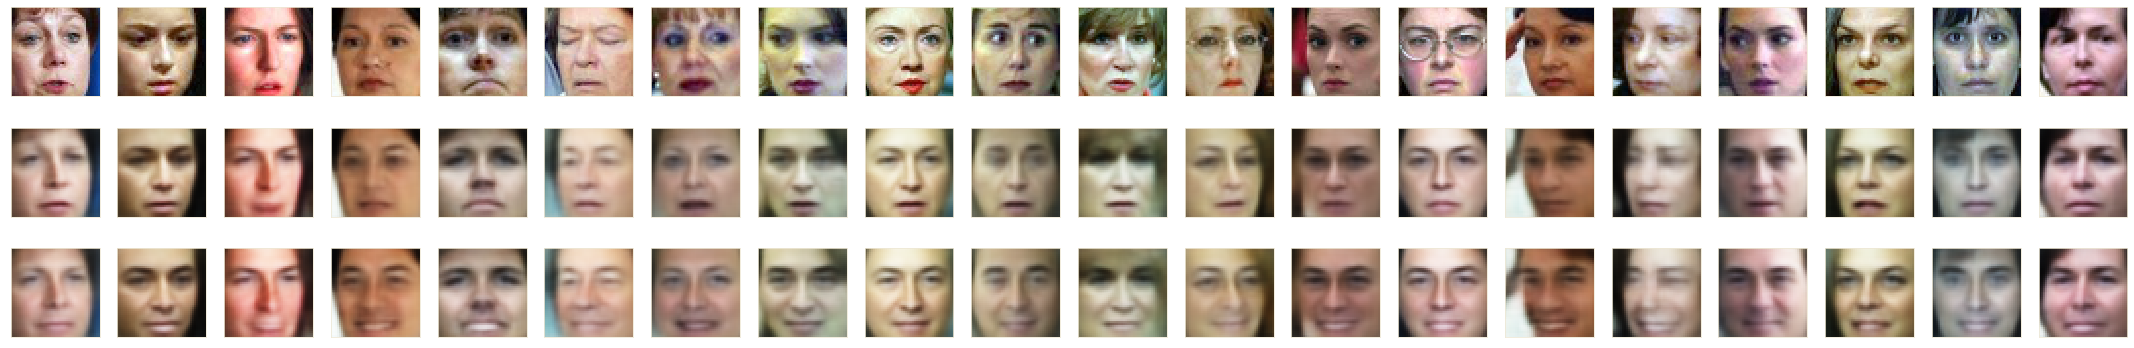

In [169]:
# Make frowning female smile 
fr_female_loader = iter(data_utils.DataLoader(Dataset(data[fr_female.index], compose=compose), batch_size=b))
with torch.no_grad():
  items = next(fr_female_loader).float().to(device)
  mu, logsigma, mu_z, rec1 = autoencoder(items) 
  mu_z += torch.tensor(diff_lats[1]).to(device) # * 0.7 for slighter mask
  rec2 = autoencoder.decoder(mu_z)
  plot_gallery(reprocess(items) + reprocess(rec1) + reprocess(rec2), image_h, image_w, n_row=3, n_col=b)

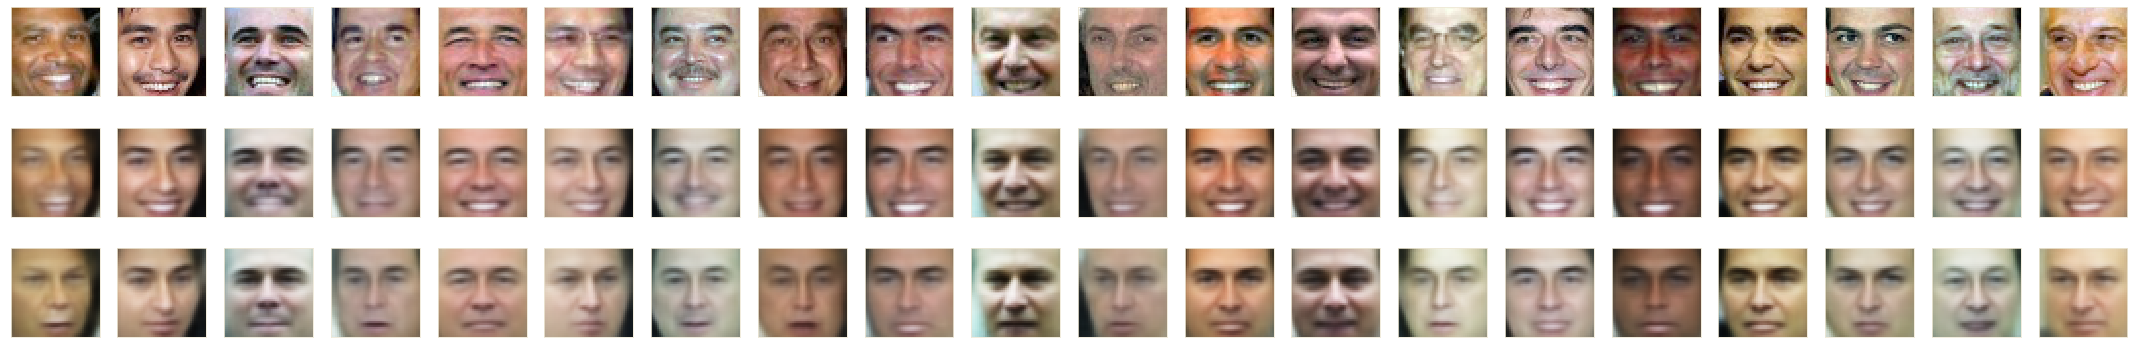

In [166]:
# Make smiling male frown 
sm_male_loader = iter(data_utils.DataLoader(Dataset(data[sm_male.index], compose=compose), batch_size=b))
with torch.no_grad():
  items = next(sm_male_loader).float().to(device)
  mu, logsigma, mu_z, rec1 = autoencoder(items)
  mu_z -= torch.tensor(diff_lats[0]).to(device) # * 0.7 for slighter mask  
  rec2 = autoencoder.decoder(mu_z)
  plot_gallery(reprocess(items) + reprocess(rec1) + reprocess(rec2), image_h, image_w, n_row=3, n_col=b)

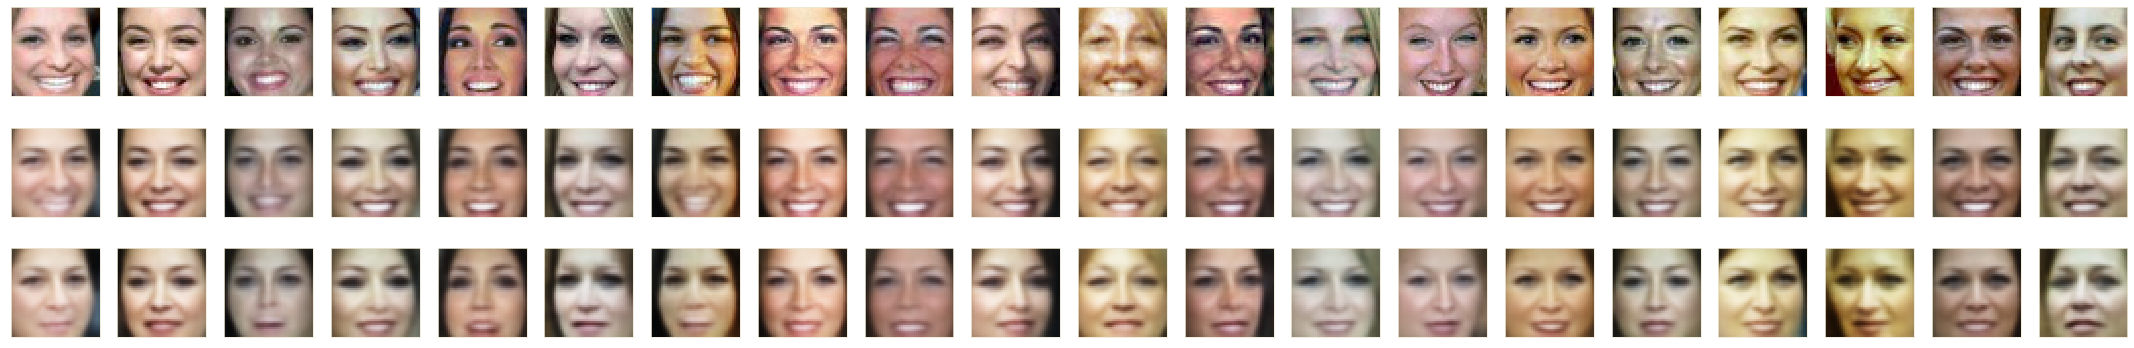

In [165]:
# Make smiling female frown 
sm_female_loader = iter(data_utils.DataLoader(Dataset(data[sm_female.index], compose=compose), batch_size=b))
with torch.no_grad():
  items = next(sm_female_loader).float().to(device)
  mu, logsigma, mu_z, rec1 = autoencoder(items)
  mu_z -= torch.tensor(diff_lats[1]).to(device) # * 0.7 for slighter mask 
  rec2 = autoencoder.decoder(mu_z)
  plot_gallery(reprocess(items) + reprocess(rec1) + reprocess(rec2), image_h, image_w, n_row=3, n_col=b)

In [0]:
params = torch.load('./drive/My Drive/Colab Notebooks/VAE_lfw.pth', map_location=device)
autoencoder.load_state_dict(params)
autoencoder.eval()

In [0]:
torch.save(autoencoder.state_dict(), './drive/My Drive/Colab Notebooks/VAE_lfw.pth')

# BONUS 2. (2 балла)

А теперь пришло время сделать 
## Conditional Variational AE

In [0]:
# <тут обучение Conditional Variational AE>
N_OUT = 128
N_CLASS = 10
N_CHANNEL = 1
IMAGE_H = 28
IMAGE_W = 28

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lc = nn.Linear(N_CLASS + IMAGE_H * IMAGE_W, IMAGE_H * IMAGE_W)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 3, 1), # -1x32x10x10
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # -1x32x5x5

            nn.Conv2d(32, 16, 3, 2, 1), # -1x16x3x3
            nn.ReLU(),
            nn.MaxPool2d(2, 1), # -1x16x2x2

            nn.Flatten(),
        )

    def forward(self, x):
        x = self.lc(x).view(-1, N_CHANNEL, IMAGE_H, IMAGE_W) # -1x1x28x28
        return self.encoder(x)


class CVEncoder(Encoder):
    def __init__(self):
        super().__init__()
        self.mu = nn.Linear(16 * 2 * 2, N_OUT)
        self.std = nn.Linear(16 * 2 * 2, N_OUT)
    
    def _bottleneck(self, x):
        x = super().forward(x)
        return self.mu(x), self.std(x)

    def forward(self, x):
        return self._bottleneck(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lc = nn.Linear(N_OUT + N_CLASS, 16 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3, 2), 
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, 5, 3, 1), 
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, 2, 2, 1),
            nn.Sigmoid()
            )

    def forward(self, x):
        x = self.lc(x).view(-1, 16, 2, 2)
        x = self.decoder(x)
        return x


class CVDecoder(Decoder):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = super().forward(x)
        return x


class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CVEncoder()
        self.decoder = CVDecoder()

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp_(logsigma * 0.5)
            eps = Variable(std.data.new(std.size()).normal_())
            return mu + std * eps
        else:
            return mu
    
    def _prep(self, x, y):
        x = torch.cat((x, y.view(-1, 1, N_CLASS, 1)), dim=2)
        x = x.view(-1, 28 * 28 + N_CLASS)
        return x

    def forward(self, x, y):
        x = self._prep(x, y)
      
        mu, logsigma = self.encoder(x)
        mu_z = self.gaussian_sampler(mu, logsigma)

        mu_z = torch.cat((mu_z, y), dim=1)

        reconstruction = self.decoder(mu_z)
        return mu, logsigma, mu_z, reconstruction  

In [0]:
# <тут Ваш код тренировки автоэнкодера>
def train_loss(model, optimizer, criterion, train_loader):
  model.train()
  running_loss = .0
  for i, (x_val, y) in enumerate(train_loader):
    optimizer.zero_grad()

    # x_val has shape -1x1x28*28x1
    # in forward y has shape -1x1x10x1
    # one_hot takes 1d array of labels and returns matrix
    x_val = x_val.float().to(device)
    y = one_hot(y, n_classes=N_CLASS)
    y = y.to(device)
    
    # encoder cats x_val & y along 2-axis and passes through convs
    mu, logsigma, mu_z, rec = model(x_val, y)

    # rec has shape -1x1x28x28
    loss = loss_vae(x_val.view_as(rec), mu, logsigma, rec)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(train_loader)


def test_loss(model, criterion, test_loader):
  model.eval()
  running_loss = .0

  with torch.no_grad():
    for i, (x_val, y) in enumerate(test_loader):
      # Same as in train_loss
      x_val = x_val.float().to(device)
      y = one_hot(y, n_classes=N_CLASS)
      y = y.to(device)

      mu, logsigma, mu_z, rec = model(x_val, y)

      loss = loss_vae(x_val.view_as(rec), mu, logsigma, rec)

      running_loss += loss.item()

  return running_loss / len(test_loader)


def generate(model, title='', seed=3):
  model.eval()
  torch.manual_seed(seed)
  with torch.no_grad():
    code = torch.randn(10, 128).to(device)

    y = torch.arange(0, N_CLASS, 1).view(-1, 1)
    # print(f'random class: {y.flatten().data}')
    y = one_hot(y).to(device)

    code = torch.cat((code, y), dim=1)

    rec = model.decoder(code)
    plot_gallery(reprocess(rec), image_h, image_w, n_col=10, n_row=1, c=1)
    plt.title(title, loc='center')

In [0]:
autoencoder = CVAE().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.0011)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.3)

Epoch 1, Train Loss: 2625.6081, Test Loss: 2472.7511
Epoch 2, Train Loss: 2590.4491, Test Loss: 2453.8367


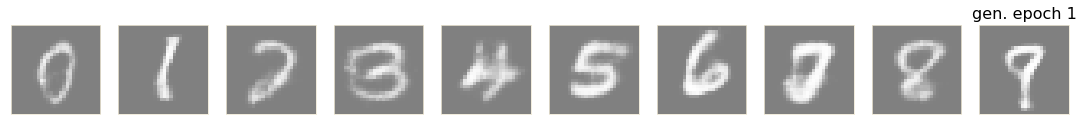

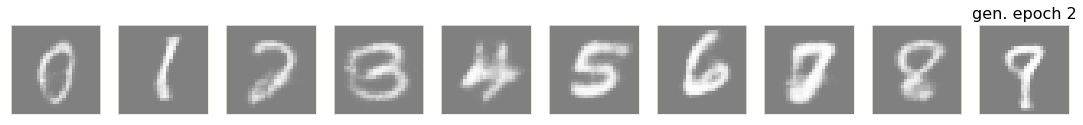

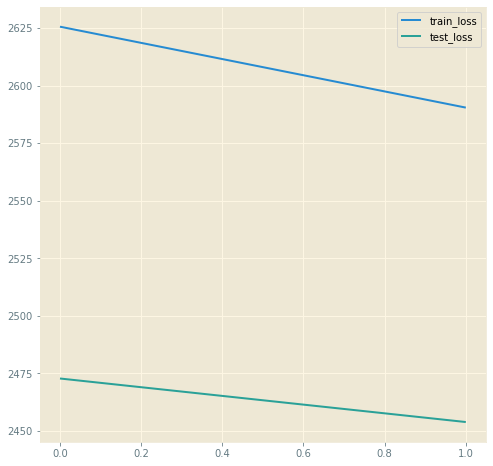

In [297]:
# 4 epochs 56, 2 epochs 40, 2 epochs 24
train_loader = data_utils.DataLoader(train_dataset, batch_size=24, num_workers=1, shuffle=True, drop_last=True)
val_loader = data_utils.DataLoader(val_dataset, batch_size=24, num_workers=1, drop_last=True)
train(autoencoder, optimizer, loss_vae, train_loader, val_loader, 2, 3)

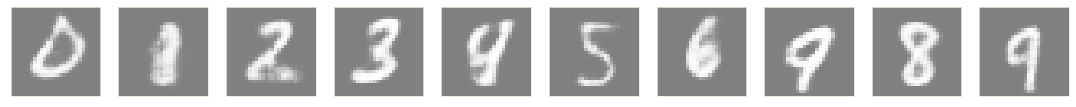

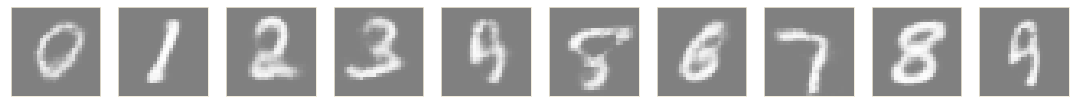

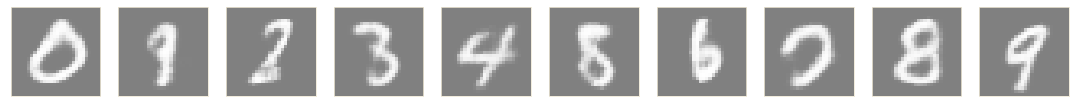

In [298]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
autoencoder.eval()
# torch.manual_seed(3)

with torch.no_grad():
    for i in range(3):
        code = torch.randn(10, N_OUT).to(device)
        y = torch.arange(0, N_CLASS, 1).view(-1, 1)
        # print(f'random class: {y.flatten().data}')
        y = one_hot(y).to(device)

        code = torch.cat((code, y), dim=1)

        rec = autoencoder.decoder(code)
        plot_gallery(reprocess(rec), image_h, image_w, n_col=10, n_row=1, c=1)

... и так же посмотреть на латентное пространство векторов VAE, как мы делали это с обычным variational AE, понять, чем же оно отличается и сделать выводы:

In [0]:
from sklearn.manifold import TSNE

autoencoder.eval()
n = 2000

x_val, y = next(iter(data_utils.DataLoader(val_dataset, num_workers=1, batch_size=n)))
with torch.no_grad():
  x_val = x_val.float().to(device)
  y = one_hot(y, n_classes=N_CLASS).to(device)
  mu, logsigma, mu_z, rec = autoencoder(x_val, y)
  mu_z = mu_z.data.cpu().numpy()

x_val_tsne1 = TSNE(n_components=2, init='pca', random_state=33).fit_transform(mu_z)
x_val_tsne2 = TSNE(n_components=2, init='random', random_state=33).fit_transform(mu_z)

y = y_val[:n]

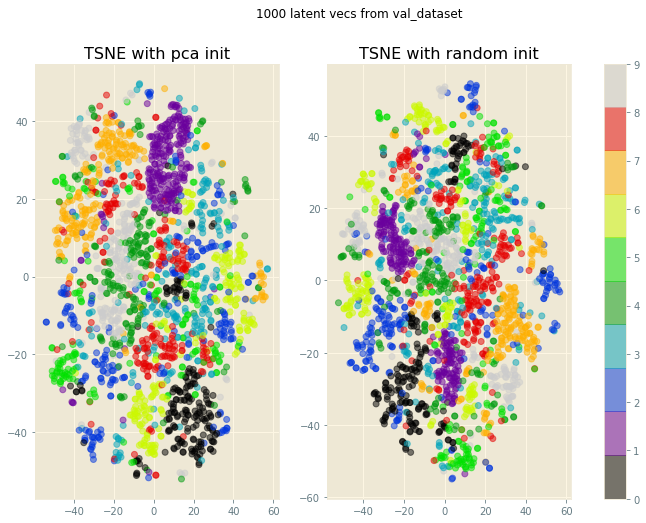

In [303]:
# <тут код>
# <тут код получения латентных векторов, прогона через TSNE и рисования scatter plot>
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

img = ax[0].scatter(x_val_tsne1[:, 0], x_val_tsne1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', N_CLASS))
ax[0].set_title('TSNE with pca init')
ax[1].scatter(x_val_tsne2[:, 0], x_val_tsne2[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', N_CLASS))
ax[1].set_title('TSNE with random init')
plt.suptitle('1000 latent vecs from val_dataset')
plt.colorbar(img, ax=ax)

<тут выводы>

Не уверен что это правильная интерпретация, очевидно точки отдельных классов должны были быть более консистентными, вернее сгустки точек одинаковых классов достаточно далеко находятся. Мне кажется я схитрил(в conditional ae, в энкодере я использовал на выходе sigmoid, что подавило большинство коефициентов [0, 1] и когда я добавлял one hot, то модель лучше находила зависимость -> за 4 epochs 64 довольно таки неплохо вышло). При той же модели в conditional vae sigmoid на выходе энкодера только усугублял обучение 

In [0]:
torch.save(autoencoder.state_dict(), './drive/My Drive/Colab Notebooks/CVAE_mnist.pth')

In [0]:
params = torch.load('./drive/My Drive/Colab Notebooks/CVAE_mnist.pth', map_location=device)
autoencoder.load_state_dict(params)
autoencoder.eval()

# BONUS 3. (2 балла)

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонксное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [0]:
def apply_gaussian_noise(X):
    noise_factor = 0.5
    X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 
    X_noisy = np.clip(X_noisy, 0, 1)
    return X_noisy

In [0]:
# <тут Ваш код>
class DenDataset(Dataset):
  def __init__(self, dataset1, dataset2, labels=None, compose=None):
      super().__init__(dataset1, labels=labels, compose=compose)
      self.dataset2 = dataset2

  def __getitem__(self, ind): 
    x1, x2 = self.dataset[ind], self.dataset2[ind]
    if self.compose is not None:
         x1, x2 = self.compose(x1), self.compose(x2)
    if self.labels is None:
        return x1, x2
    else: 
        return x1, x2, self.labels[ind]


compose = transforms.Compose([
                              transforms.ToTensor(),
                              ])    

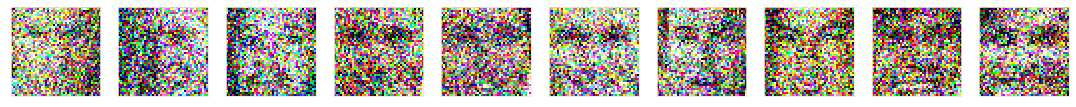

In [239]:
plot_gallery(apply_gaussian_noise(data[:10]), image_h, image_w, n_row=1, n_col=10)

In [0]:
# We shoud not use train_test_split as long as we also have 'attrs' dataframe
X_train, X_val, X_train_gaus, X_val_gaus = train_test_split(data, apply_gaussian_noise(data), train_size=TRAIN_SIZE, random_state=3)
train_dataset = DenDataset(X_train, X_train_gaus, compose=compose)
val_dataset = DenDataset(X_val, X_val_gaus, compose=compose)

In [0]:
N_OUT = 256


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, padding_mode='same'), # 32x22x22 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.3),

            nn.Conv2d(32, 64, 4, 2, 1, padding_mode='same'), # 64x11x11
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),

            nn.Conv2d(64, 128, 3, 2, 1, padding_mode='same'), # 128x6x6
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),

            nn.Conv2d(128, 256, 3, 2, 1, padding_mode='same'), # 256x3x3
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3),
            
            nn.Flatten(), # 256 * 3 * 3
            nn.Linear(256 * 3 * 3, N_OUT)
        )
    def forward(self, x):
      return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lc = nn.Linear(N_OUT, 256 * 3 * 3)
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(256, 128, 3, 1, 1, padding_mode='same'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),

            nn.Upsample(scale_factor=2), 
            nn.Conv2d(128, 64, 3, 1, 1, padding_mode='same'),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),

            nn.Upsample(scale_factor=2), 
            nn.Conv2d(64, 32, 3, 1, 1, padding_mode='same'),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.3),

            nn.Upsample(scale_factor=2), 
            nn.Conv2d(32, 3, 4, 1, padding_mode='same'),

            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.lc(x).view(-1, 256, 3, 3)
        return self.decoder(x)


class DenoiseAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)  
        return latent, reconstructed 

In [0]:
# <обучите модель, как и autoencoder>

# <тут Ваш код тренировки автоэнкодера>
def train_loss(model, optimizer, criterion, train_loader):
  model.train()
  running_loss = .0
  for i, (x_val1, x_val2) in enumerate(train_loader):
    optimizer.zero_grad()

    x_val1, x_val2 = x_val1.float().to(device), x_val2.float().to(device)
    lat, rec = model(x_val2)

    loss = criterion(x_val1, rec)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(train_loader)


def test_loss(model, criterion, test_loader):
  model.eval()
  running_loss = .0

  with torch.no_grad():
    for i, (x_val1, x_val2) in enumerate(test_loader):
      # Same as in train_loss
      x_val1, x_val2 = x_val1.float().to(device), x_val2.float().to(device)

      lat, rec = model(x_val2)

      loss = criterion(x_val1, rec)

      running_loss += loss.item()

  return running_loss / len(test_loader)

In [0]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>
criterion = nn.MSELoss()

autoencoder = DenoiseAE().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.00014)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

In [0]:
# 64 32 40 - noise 0.2
# 40 24 56 32 - noise 0.5
b = 32
train_loader = data_utils.DataLoader(train_dataset, batch_size=b, num_workers=1, shuffle=True, drop_last=True)
val_loader = data_utils.DataLoader(val_dataset, batch_size=b, num_workers=1, drop_last=True)
train(autoencoder, optimizer, criterion, train_loader, val_loader, 5, 3)

In [0]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

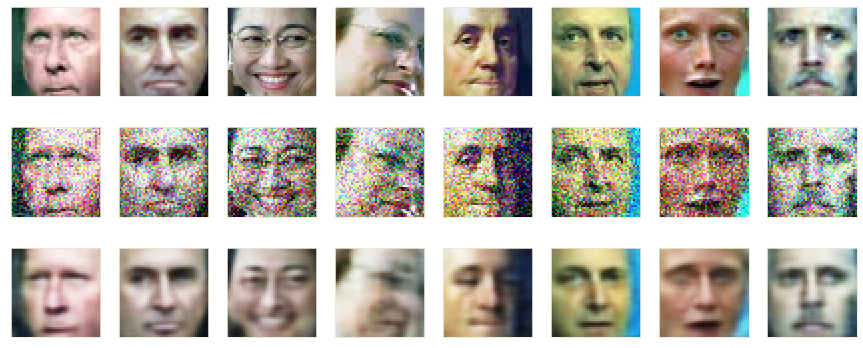

In [237]:
# noise factor 0.2 in gaussian_noise
autoencoder.eval()
x_val1, x_val2 = next(iter(data_utils.DataLoader(val_dataset, batch_size=32, num_workers=1, drop_last=True, shuffle=True)))
with torch.no_grad():
  x_val1, x_val2 = x_val1.float().to(device), x_val2.float().to(device)
  lat, rec = autoencoder(x_val2)
  plot_gallery(reprocess(x_val1[:8]) + reprocess(x_val2[:8]) + reprocess(rec), image_h, image_w, n_row=3, n_col=8)  

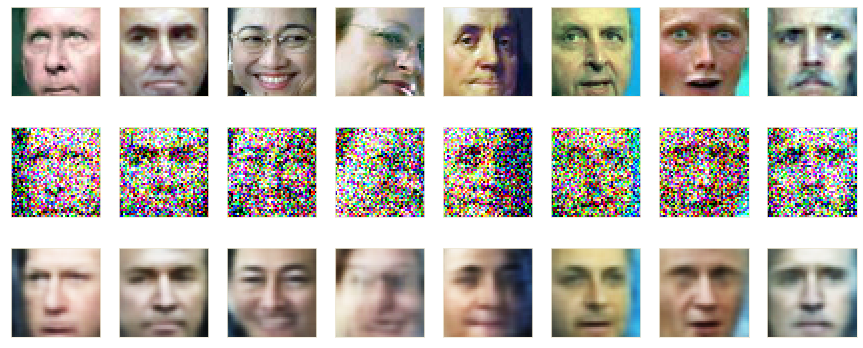

In [257]:
# noise factor 0.5 in gaussian_noise
autoencoder.eval()
x_val1, x_val2 = next(iter(data_utils.DataLoader(val_dataset, batch_size=32, num_workers=1, drop_last=True, shuffle=True)))
with torch.no_grad():
  x_val1, x_val2 = x_val1.float().to(device), x_val2.float().to(device)
  lat, rec = autoencoder(x_val2)
  plot_gallery(reprocess(x_val1[:8]) + reprocess(x_val2[:8]) + reprocess(rec), image_h, image_w, n_row=3, n_col=8)  

In [0]:
torch.save(autoencoder.state_dict(), './drive/My Drive/Colab Notebooks/Denoise_lfw.pth')

In [0]:
params = torch.load('./drive/My Drive/Colab Notebooks/Denoise_lfw.pth', map_location=device)
autoencoder.load_state_dict(params)
autoencoder.eval()

# Bonus 4. (2+ балла)

Пишем телеграм-бота!

Можно написать телеграм-бота, которому на вход вы подаете, например, картинку без улыбки, а он вам возвращает с улыбкой.

Или еще много вариантов, чего может уметь делать бот. Придумайте сами)

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!